In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.9 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from transformers import  BeitFeatureExtractor, BeitForImageClassification

model = BeitForImageClassification.from_pretrained("jadohu/BEiT-finetuned")

In [ ]:
model

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

In [ ]:
sum([l.numel() for l in model.parameters()])

85769674

In [7]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

optimizer = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss().to(device)
model.to(device)

model.train()
for epoch in range(epochs): 
  print("Epoch:", epoch)
  losses = []
  
  for idx, data in enumerate(trainloader):
    inputs, labels = data
    pixel_values = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(pixel_values=pixel_values.squeeze(1))
    l = loss(outputs.logits, labels)

    l.backward()
    optimizer.step()

    losses.append(l.item())

  print("\t Loss:", sum(losses)/len(losses))

Epoch: 0
	 Loss: 1.7394749669719223
Epoch: 1
	 Loss: 1.4057737993111004
Epoch: 2
	 Loss: 1.2311617908993366
Epoch: 3
	 Loss: 1.1053410907510146
Epoch: 4
	 Loss: 0.9854935388380491
Epoch: 5
	 Loss: 0.8862873429834118
Epoch: 6


KeyboardInterrupt: ignored

In [8]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 34.6 MB/s eta 0:00:00


In [9]:
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision , BinaryRecall

acc = BinaryAccuracy()
prec = BinaryPrecision()

softmax = nn.Softmax(dim=1)

targets = []
model_predicts = []
losses = []
model.eval() 
acc_list = []
pre_list = []
with torch.no_grad():
  for idx, data in enumerate(trainloader):
    inputs, labels = data
    
    X = inputs.to(device)
    l = labels.to(device)

    out = model(X.squeeze(1))
    out = out.logits
    loss_t = loss(out, l)
    losses.append(loss_t.item())
    
    out = softmax(out)

    ls = torch.zeros(out.shape[0], 10)
    for i in range(out.shape[0]):
      ls[i][l[i]] = 1.

    acc_list.append(acc(out.cpu(), ls.cpu()))
    pre_list.append(prec(out.cpu(), ls.cpu()))

    targets.extend((torch.max(ls, 1)[1]).data.cpu().numpy())
    model_predicts.extend((torch.max(out, 1)[1]).data.cpu().numpy())

  print(f'test loss : {sum(losses)/len(losses)}')
  print(f'test accuracy : {sum(acc_list)/len(acc_list)}')
  print(f'test precision : {sum(pre_list)/len(pre_list)}')

test loss : 0.742321598724303
test accuracy : 0.9503218531608582
test precision : 0.8155014514923096


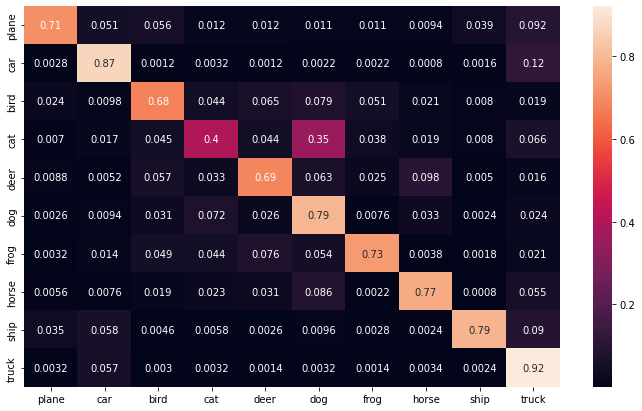

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

cf_matrix = confusion_matrix(targets, model_predicts)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*10, 
                     index = [i for i in classes],
                     columns = [i for i in classes]
                     )
plt.figure(figsize = (12, 7))
sns.heatmap(df_cm, annot=True)
plt.show()